# Fraud detection using credit card transaction data

**1. Load the data**



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,6)})

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard_clean.csv')

**2. Feature Engineering (Case 1)**



In [3]:
# 3.1 posEntryMode
df['posEM_new'] = np.where(df['posEntryMode'] == '', '999',df['posEntryMode'])

# 3.2 transactionAmount and creditLimit
df['amountOver'] = np.where(df['transactionAmount'] > df['creditLimit'], 1, 0)

# 3.3 cardCVV and enteredCVV
df['cvvNotSame'] =  np.where(df['cardCVV'] != df['enteredCVV'], 1, 0)

# 3.4 DateTime
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['hour'] = df['transactionDateTime'].dt.hour

# 3.5 Create a new dataframe
df1 = df[['isFraud','cvvNotSame','amountOver', 'posEM_new', 'hour', 'transactionAmount', 'availableMoney', 'cardPresent', 'merchantCategoryCode']]
df1 = pd.get_dummies(columns=['posEM_new'], data = df1)
df1 = pd.get_dummies(columns=['merchantCategoryCode'], data = df1)
df_final = df1.dropna()
df_final.head()

,isFraud,cvvNotSame,amountOver,hour,transactionAmount,availableMoney,cardPresent,posEM_new_2.0,posEM_new_5.0,posEM_new_80.0,posEM_new_9.0,posEM_new_90.0,posEM_new_nan,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions
0,False,0,0,0,44.09,50000.0,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,False,0,0,0,329.57,5000.0,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,False,0,0,0,164.57,20000.0,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,0,0,0,122.83,10000.0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,False,0,0,0,24.56,250.0,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


For this fraud detection task, I will use ROC_AUC as the primary metric.

**2.1 Train-test split**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('isFraud', axis = 1),
                                                    df_final['isFraud'],
                                                    stratify = df_final['isFraud'],
                                                    test_size = 0.2,
                                                    random_state = 123)

In [5]:
print(X_train.shape)
print(X_test.shape)

(604399, 31)
(151100, 31)


In [6]:
print(y_train.mean())
print(y_test.mean())

0.016080436929908886
0.016082064857710125


**2.2 Model1 - Logistic regression**

In [7]:
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# 5-fold cross validation
cross_val_score(clf_lr, X_train, y_train, scoring = "roc_auc", cv = 5)

array([0.68810393, 0.69329767, 0.69129858, 0.68712917, 0.68624971])

In [9]:
# Other metrics
y_pred_lr = clf_lr.predict(X_test)
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.9839113170086036
precision:  0.0
recall:  0.0
confusion matrix:  [[148669      1]
 [  2430      0]]


In [10]:
y_pred_p = clf_lr.predict_proba(X_test)
y_pred_p[0:10]

array([[0.95534228, 0.04465772],
       [0.99236791, 0.00763209],
       [0.95557677, 0.04442323],
       [0.99661141, 0.00338859],
       [0.97660175, 0.02339825],
       [0.99206046, 0.00793954],
       [0.9477368 , 0.0522632 ],
       [0.99533258, 0.00466742],
       [0.99641309, 0.00358691],
       [0.99476509, 0.00523491]])

In [11]:
# Replace the threshold with the percentage of the fraud transactions in the dataset.
y_pred_lr = np.where(y_pred_p[:,1]> 0.016, 1,0)
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.6174718729318333
precision:  0.02746296169864136
recall:  0.6621399176954732
confusion matrix:  [[91691 56979]
 [  821  1609]]


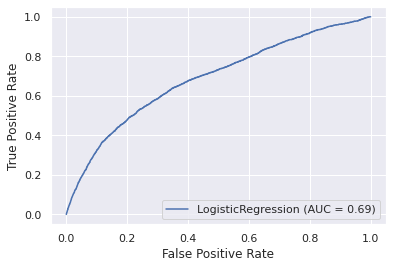

In [12]:
# Plot roc
metrics.plot_roc_curve(clf_lr, X_test, y_test)  
plt.show()  

I will use 0.69 as the base.

**2.3  Model2 - Logistic regression (scaling)**

In [13]:
# Scale the dataframe
min_max_scaler = MinMaxScaler()
df_final_scaled = min_max_scaler.fit_transform(df_final.values)
df_final2 = pd.DataFrame(df_final_scaled)
df_final2.columns = df_final.columns
df_final2.head()

,isFraud,cvvNotSame,amountOver,hour,transactionAmount,availableMoney,cardPresent,posEM_new_2.0,posEM_new_5.0,posEM_new_80.0,posEM_new_9.0,posEM_new_90.0,posEM_new_nan,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions
0,0.0,0.0,0.0,0.0,0.021914,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.163835,0.117744,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.081808,0.411830,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.061058,0.215773,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.012205,0.024617,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df_final2.drop('isFraud', axis = 1),
                                                    df_final2['isFraud'],
                                                    stratify = df_final2['isFraud'],
                                                    test_size = 0.2,
                                                    random_state = 123)

In [15]:
# Apply the logistic model
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# Replace the threshold
y_pred_p = clf_lr.predict_proba(X_test)
y_pred_lr = np.where(y_pred_p[:,1]> 0.016, 1,0)


In [17]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.6502448709463932
precision:  0.032057469557469555
recall:  0.7106995884773663
confusion matrix:  [[96525 52145]
 [  703  1727]]


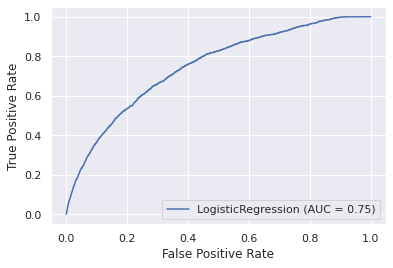

In [18]:
# Plot roc_auc
metrics.plot_roc_curve(clf_lr, X_test, y_test)  
plt.show()  

Compare 2 roc_auc results before and after scaling the dataframe, it can be concluded that scaling the dataframe increases the value of the metric. Therefore, I will use the scaling dataframe in the following modeling experiments.

**2.4 XGBoost (Scaling)**

In [19]:
# Fit the model
xgb_clf = XGBClassifier(n_estimators=200, 
                        learning_rate=0.1
                        )
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
# Replace the metric
y_pred_xgb = xgb_clf.predict_proba(X_test)
y_pred_xgb = np.where(y_pred_xgb[:,1]> 0.016, 1,0)

In [21]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_xgb))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_xgb))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_xgb))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_xgb))

accuracy:  0.7153871608206486
precision:  0.0365081903543442
recall:  0.6576131687242799
confusion matrix:  [[106497  42173]
 [   832   1598]]


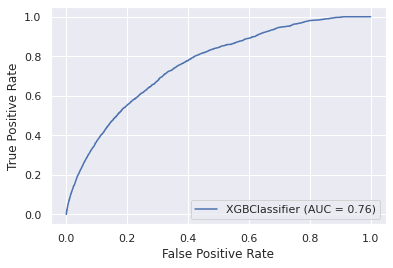

In [22]:
# Plot roc_auc
metrics.plot_roc_curve(xgb_clf, X_test, y_test)  
plt.show()  

In [23]:
# Grid search
xgb_clf = XGBClassifier()

xgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 400, 100),
                  }

random_xgb = RandomizedSearchCV(estimator=xgb_clf, 
                                    param_distributions=xgb_param_grid,
                                    n_iter=100, 
                                    scoring='roc_auc', 
                                    cv=2,
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_xgb.fit(X_train, y_train)
print("Best parameters found: ",random_xgb.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  8.4min finished


Best parameters found:  {'n_estimators': 300, 'learning_rate': 0.1}


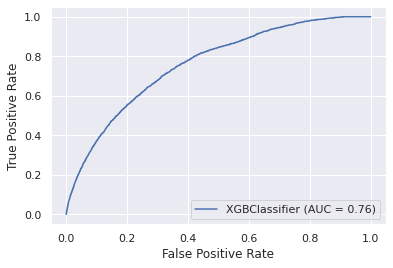

In [24]:
# Use the best parameter to calculate roc_auc
xgb_clf = XGBClassifier(n_estimators=300, 
                        learning_rate=0.1
                        )
xgb_clf.fit(X_train, y_train)

# Plot roc_auc
metrics.plot_roc_curve(xgb_clf, X_test, y_test)  
plt.show()  

**2.5 LightGBM**

In [25]:
# Fit the model
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         max_depth=10,
                         learning_rate = 0.1
                         )
lgb_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
# Replace the threshold
y_pred_lgb = lgb_clf.predict_proba(X_test)
y_pred_lgb = np.where(y_pred_lgb[:,1]> 0.016, 1,0)

In [27]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lgb))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lgb))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lgb))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lgb))

accuracy:  0.7104037061548644
precision:  0.03607830811369045
recall:  0.6613168724279835
confusion matrix:  [[105735  42935]
 [   823   1607]]


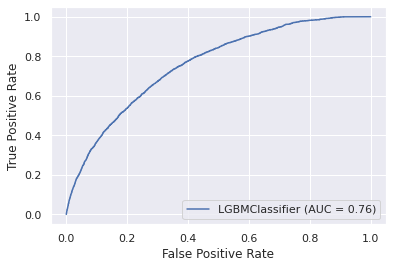

In [28]:
# Plot roc_auc
metrics.plot_roc_curve(lgb_clf, X_test, y_test)  
plt.show()  

In [29]:
# Grid search
lgb_clf = LGBMClassifier()

lgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 600, 200),
                  'max_depth': [5,10]
                  }

random_lgb = RandomizedSearchCV(estimator=lgb_clf, 
                                    param_distributions=lgb_param_grid,
                                    n_iter=100, 
                                    scoring='roc_auc', 
                                    cv=2, 
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_lgb.fit(X_train, y_train)
print("Best parameters found: ",random_lgb.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished


Best parameters found:  {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}


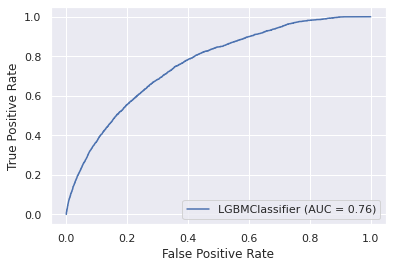

In [30]:
# Use the best parameter to caculate roc_auc
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         max_depth=5,
                         learning_rate = 0.05
                         )
lgb_clf.fit(X_train, y_train)

# Plot roc
metrics.plot_roc_curve(lgb_clf, X_test, y_test)  
plt.show()  

**2.6 Feature Importance**

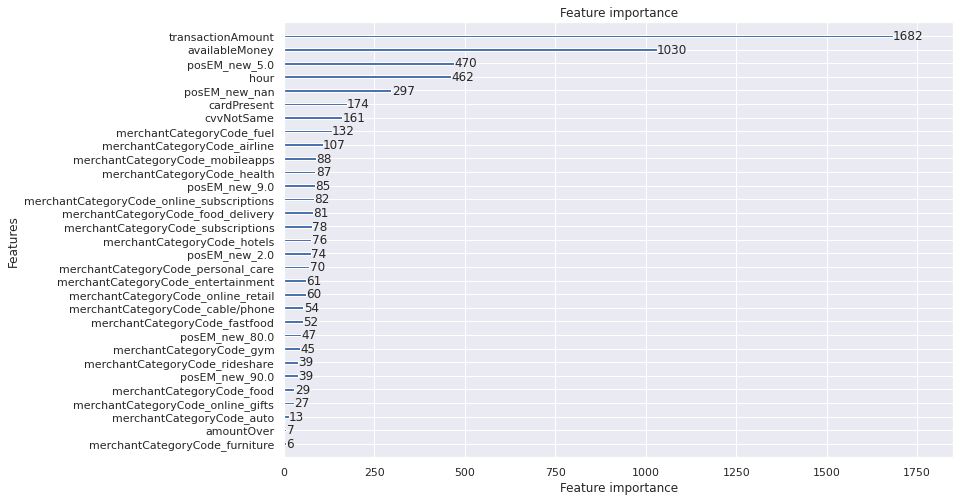

In [31]:
sns.set(rc={'figure.figsize':(12,8)})
plot_importance(lgb_clf)

*For this feature combination, XGBoost and LightGBM both achieved 0.76 for the roc_auc, outperforming Logistic regression. Additionally, LightGBM was computationally faster than XGBoost.

*It seems like "merchantCategoryCode" is relevantly not important, we can try drop this feature in the next experiment.


**3. Feature Engineering (Case 2)**

**3.1 Train-Test split**

In [32]:
# Creat a new dataframe
df2 = df[['isFraud','cvvNotSame','amountOver', 'posEM_new', 'hour', 'transactionAmount', 'availableMoney', 'cardPresent']]
df2 = pd.get_dummies(columns=['posEM_new'], data = df2)
df2_final = df2.dropna()
df2_final.head()

,isFraud,cvvNotSame,amountOver,hour,transactionAmount,availableMoney,cardPresent,posEM_new_2.0,posEM_new_5.0,posEM_new_80.0,posEM_new_9.0,posEM_new_90.0,posEM_new_nan
0,False,0,0,0,44.09,50000.0,False,0,0,0,1,0,0
1,False,0,0,0,329.57,5000.0,False,0,0,0,1,0,0
2,False,0,0,0,164.57,20000.0,False,0,1,0,0,0,0
3,False,0,0,0,122.83,10000.0,False,1,0,0,0,0,0
4,False,0,0,0,24.56,250.0,False,0,1,0,0,0,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df2_final.drop('isFraud', axis = 1),
                                                    df2_final['isFraud'],
                                                    stratify = df2_final['isFraud'],
                                                    test_size = 0.2,
                                                    random_state = 123)

In [34]:
print(X_train.shape)
print(X_test.shape)

(604399, 12)
(151100, 12)


In [35]:
print(y_train.mean())
print(y_test.mean())

0.016080436929908886
0.016082064857710125


**3.2 Model1 - Logistic regression**

In [36]:
# Fit the model
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# 5-fold cross validation
cross_val_score(clf_lr, X_train, y_train, scoring = "roc_auc", cv = 5)

array([0.69932994, 0.70124737, 0.71063303, 0.70757814, 0.69499047])

In [39]:
# Other metrics
y_pred_lr = clf_lr.predict(X_test)
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.9839113170086036
precision:  0.0
recall:  0.0
confusion matrix:  [[148669      1]
 [  2430      0]]


In [40]:
y_pred_p = clf_lr.predict_proba(X_test)
y_pred_p[0:10]

array([[0.95707036, 0.04292964],
       [0.9940801 , 0.0059199 ],
       [0.94788398, 0.05211602],
       [0.99753401, 0.00246599],
       [0.9747505 , 0.0252495 ],
       [0.99100068, 0.00899932],
       [0.93872172, 0.06127828],
       [0.99469646, 0.00530354],
       [0.99619876, 0.00380124],
       [0.99571087, 0.00428913]])

In [41]:
# Replace the threshold with the percentage of the fraud transactions in the dataset.
y_pred_lr = np.where(y_pred_p[:,1]> 0.016, 1,0)
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.6243547319655857
precision:  0.027975673327541268
recall:  0.6625514403292181
confusion matrix:  [[92730 55940]
 [  820  1610]]


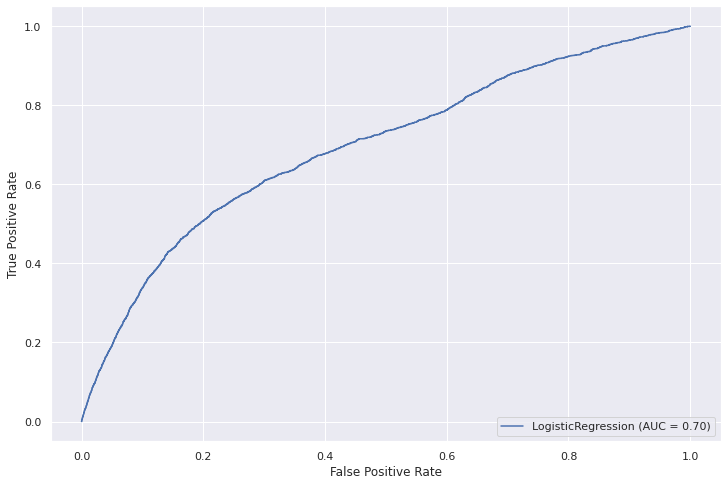

In [42]:
# Plot roc
metrics.plot_roc_curve(clf_lr, X_test, y_test)  
plt.show()  

I will use 0.70 as the base.

**3.3  Model2 - Logistic regression (scaling)**

In [43]:
# Scale the dataframe
min_max_scaler = MinMaxScaler()
df_final_scaled = min_max_scaler.fit_transform(df2_final.values)
df_final2 = pd.DataFrame(df_final_scaled)
df_final2.columns = df2_final.columns
df_final2.head()

,isFraud,cvvNotSame,amountOver,hour,transactionAmount,availableMoney,cardPresent,posEM_new_2.0,posEM_new_5.0,posEM_new_80.0,posEM_new_9.0,posEM_new_90.0,posEM_new_nan
0,0.0,0.0,0.0,0.0,0.021914,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.163835,0.117744,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.081808,0.411830,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.061058,0.215773,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.012205,0.024617,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [44]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df_final2.drop('isFraud', axis = 1),
                                                    df_final2['isFraud'],
                                                    stratify = df_final2['isFraud'],
                                                    test_size = 0.2,
                                                    random_state = 123)

In [45]:
# Apply the logistic model
clf_lr = LogisticRegression(max_iter=500)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
# Replace the threshold
y_pred_p = clf_lr.predict_proba(X_test)
y_pred_lr = np.where(y_pred_p[:,1]> 0.016, 1,0)

In [47]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lr))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lr))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lr))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lr))

accuracy:  0.6347121111846459
precision:  0.02978238009517529
recall:  0.6876543209876543
confusion matrix:  [[94234 54436]
 [  759  1671]]


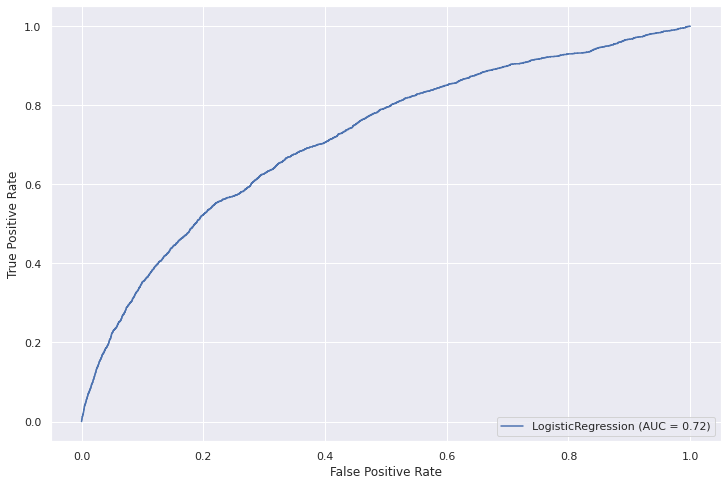

In [48]:
# Plot roc
metrics.plot_roc_curve(clf_lr, X_test, y_test)  
plt.show()  

* Compare 2 roc_auc results before and after scaling the dataframe, it can be concluded that scaling the dataframe increases the value of the metric. Therefore, I will use the scaling dataframe in the following modeling experiments.

**3.4  Model3 - XGBoost (scaling)**

In [49]:
# Fit the model
xgb_clf = XGBClassifier(n_estimators=200, 
                        learning_rate=0.1,
                        )
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
# Replace the threshold
y_pred_xgb = xgb_clf.predict_proba(X_test)
y_pred_xgb = np.where(y_pred_xgb[:,1]> 0.016, 1,0)

In [51]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_xgb))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_xgb))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_xgb))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_xgb))

accuracy:  0.7207809397749835
precision:  0.035383752453959055
recall:  0.6230452674897119
confusion matrix:  [[107396  41274]
 [   916   1514]]


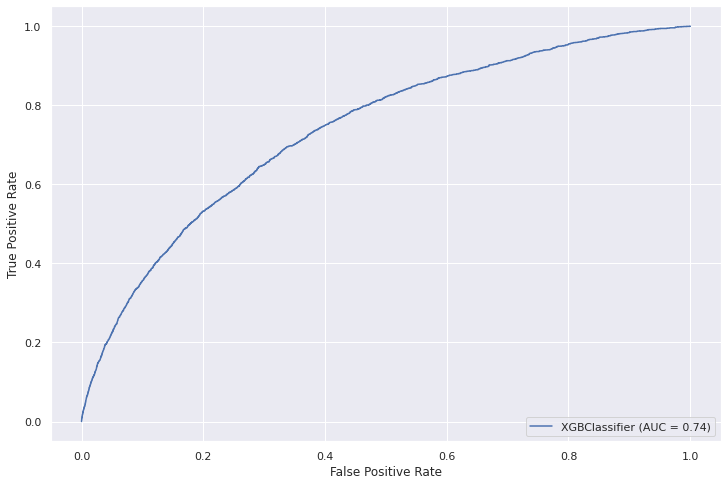

In [52]:
# Plot roc
metrics.plot_roc_curve(xgb_clf, X_test, y_test)  
plt.show()  

In [53]:
# Grid search
xgb_clf = XGBClassifier()

xgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 400, 100),
                  }

random_xgb = RandomizedSearchCV(estimator=xgb_clf, 
                                    param_distributions=xgb_param_grid,
                                    n_iter=100, 
                                    scoring='roc_auc', 
                                    cv=2,
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_xgb.fit(X_train, y_train)
print("Best parameters found: ",random_xgb.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  5.7min finished


Best parameters found:  {'n_estimators': 200, 'learning_rate': 0.05}


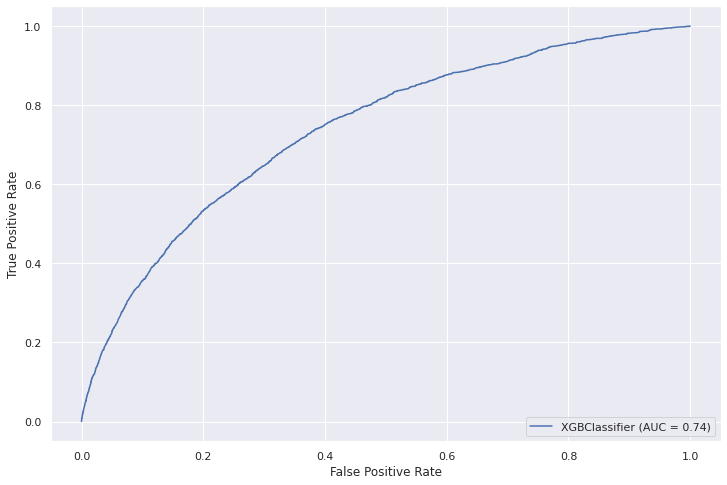

In [54]:
# Use the best parameter to calculate roc_auc
xgb_clf = XGBClassifier(n_estimators=200, 
                        learning_rate=0.05,
                        )
xgb_clf.fit(X_train, y_train)

metrics.plot_roc_curve(xgb_clf, X_test, y_test)  
plt.show() 

**3.5  Model4 - LightGBM**

In [55]:
# Fit the model
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         max_depth=10,
                         learning_rate = 0.1
                         )
lgb_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [56]:
# Replace the threshold
y_pred_lgb = lgb_clf.predict_proba(X_test)
y_pred_lgb = np.where(y_pred_lgb[:,1]> 0.016, 1,0)

In [57]:
# Other metrics
print("accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = y_pred_lgb))
print("precision: ",metrics.precision_score(y_true = y_test, y_pred = y_pred_lgb))
print("recall: ",metrics.recall_score(y_true = y_test, y_pred = y_pred_lgb))
print("confusion matrix: ",metrics.confusion_matrix(y_test, y_pred_lgb))

accuracy:  0.7153342157511582
precision:  0.0343957229067713
recall:  0.6168724279835391
confusion matrix:  [[106588  42082]
 [   931   1499]]


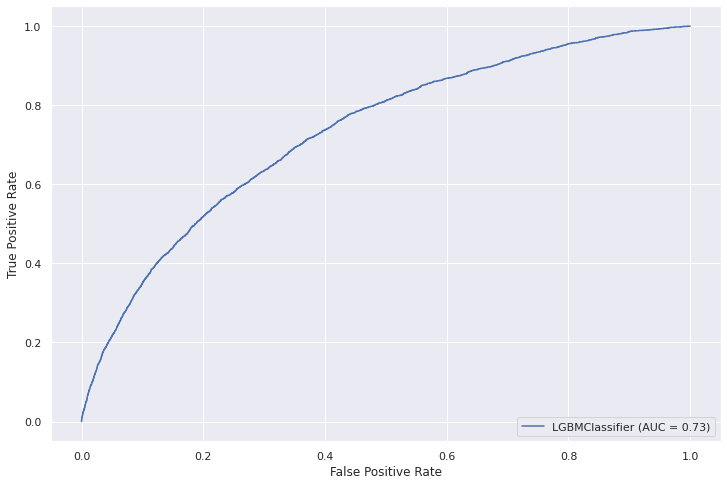

In [58]:
# Plot roc_auc
lr_probs = lgb_clf.predict_proba(X_test)

metrics.plot_roc_curve(lgb_clf, X_test, y_test)  
plt.show()  

In [59]:
# Grid search
lgb_clf = LGBMClassifier()

lgb_param_grid = {'learning_rate': np.arange(0.05, 0.15, 0.05),
                  'n_estimators': np.arange(200, 600, 200),
                  'max_depth': [5,10]
                  }

random_lgb = RandomizedSearchCV(estimator=lgb_clf, 
                                    param_distributions=lgb_param_grid,
                                    n_iter=100, 
                                    scoring='roc_auc', 
                                    cv=2, 
                                    verbose=1,
                                    n_jobs=-1
                                    )
random_lgb.fit(X_train, y_train)
print("Best parameters found: ",random_lgb.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished


Best parameters found:  {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}


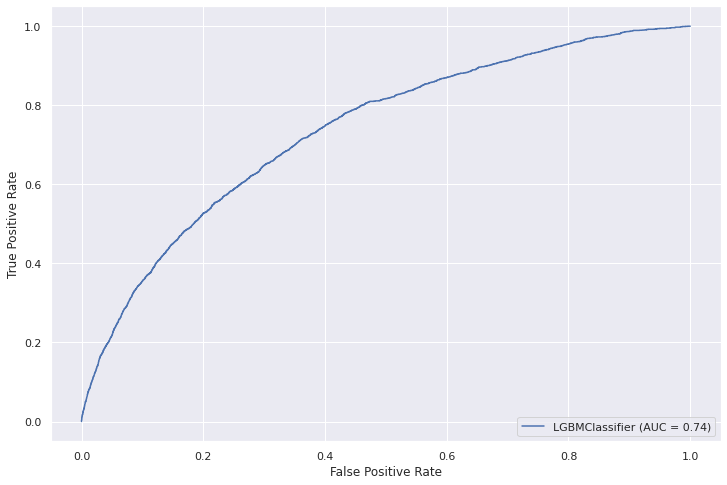

In [60]:
# Use the best parameter to caculate roc_auc
lgb_clf = LGBMClassifier(n_estimators = 200, 
                         max_depth=10,
                         learning_rate = 0.05
                         )
lgb_clf.fit(X_train, y_train)

# Plot roc_auc
metrics.plot_roc_curve(lgb_clf, X_test, y_test)  
plt.show()  

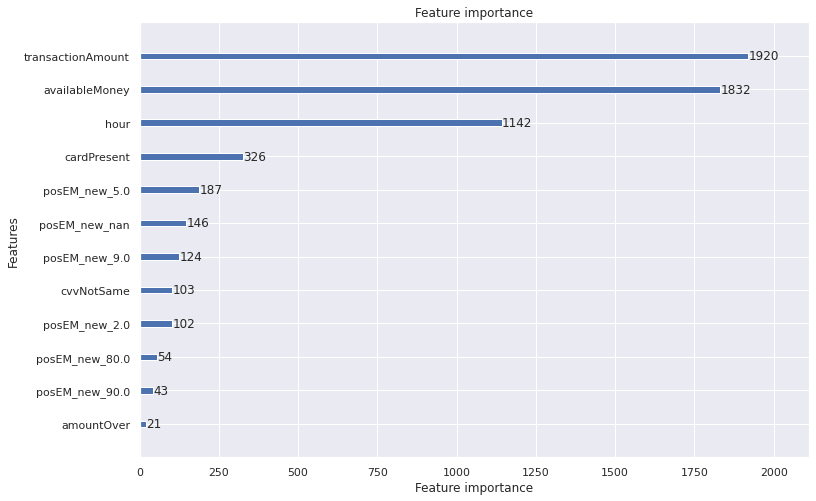

In [61]:
plot_importance(lgb_clf)

* In this feature combination, XGBoost and LightGBM both achieved 0.74 for the roc_auc, outperforming Logistic regression.